### Learning a single weight in a student-teacher training paradigm with conductance-based neurons

In this notebook, we:

* Define a simple teacher network in which a single conductance-based neuron is driven by 10 input Poisson spiketrains with random weights
* Initialise a student network with the same input but randomly initialised feedforward weights
* Train the student network to recover the weights using BPTT on the van Rossum loss

In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Define model parameters
dt = 1.0  # time step in ms
tau_m = 20.0  # membrane time constant in ms
tau_syn = 10.0  # synaptic time constant in ms
E_syn_e = 0.0  # excitatory synaptic reversal potential in mV
E_syn_i = -70.0  # inhibitory synaptic reversal potential in mV
E_L = -60.0  # resting potential in mV
v_reset = -60.0  # reset potential in mV
theta = -38.0  # spike threshold in mV
g_L = 1.35  # leak conductance in nS
g_syn_e = 2.0  # excitatory synaptic conductance (per spike per weight) in nS
g_syn_i = 4.0  # inhibitory synaptic conductance (per spike per weight) in nS

alpha = torch.exp(torch.tensor(-dt / tau_m))  # membrane decay factor
beta = torch.exp(torch.tensor(-dt / tau_syn))  # synaptic decay factor
C_m = tau_m * g_L  # membrane capacitance in nF

In [3]:
# Define the surrogate gradient function for spiking neurons


class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 0.2  # Hardcoded surrogate gradient scale

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        (input,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0) ** 2
        return grad

In [4]:
# Define teacher network
w_exc = torch.rand(4)  # 4 excitatory weights randomly initialized between 0 and 0.5
w_inh = torch.rand(1)  # 1 inhibitory weight randomly initialized between 0 and 1
w_teacher_exc = w_exc.clone()  # Save the teacher excitatory weights
w_teacher_inh = w_inh.clone()  # Save the teacher inhibitory weights

In [ ]:
# Define the feedforward neuron model
def conductance_neuron_step(
    v: torch.Tensor,
    g_exc: torch.Tensor,
    g_inh: torch.Tensor,
    s_in_exc: torch.Tensor,
    s_in_inh: torch.Tensor,
) -> torch.Tensor:
    """
    Single time step inference of conductance-based LIF neuron model with
    exponential synapses.

    Parameters:
    v: (batch,) membrane potential
    g_exc: (batch,) excitatory synaptic conductance
    g_inh: (batch,) inhibitory synaptic conductance
    s_in_exc: (batch, n_exc) excitatory input spikes
    s_in_inh: (batch, n_inh) inhibitory input spikes
    """

    # Update conductances
    g_exc = g_exc * beta + g_syn_e * (s_in_exc @ w_exc)
    g_inh = g_inh * beta + g_syn_i * (s_in_inh @ w_inh)

    # Update membrane potential with separate excitatory and inhibitory currents
    v = (
        E_L
        + (v - E_L) * alpha
        - g_exc * (v - E_syn_e) * dt / C_m
        - g_inh * (v - E_syn_i) * dt / C_m
    )

    # Compute spike
    s = SurrGradSpike.apply(v - theta)

    # Reset membrane potential if spiked
    v = v * (1 - s.detach()) + v_reset * s.detach()

    return v, g_exc, g_inh, s


def conductance_neuron(
    v_init: torch.Tensor,
    g_exc_init: torch.Tensor,
    g_inh_init: torch.Tensor,
    input_spikes_exc: torch.Tensor,
    input_spikes_inh: torch.Tensor,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, list, list, list]:
    """
    Multi time step inference of conductance-based LIF neuron model

    Parameters:
    v_init: (batch,) initial membrane potential
    g_exc_init: (batch,) initial excitatory synaptic conductance
    g_inh_init: (batch,) initial inhibitory synaptic conductance
    input_spikes_exc: (batch, time, n_exc) excitatory input spikes
    input_spikes_inh: (batch, time, n_inh) inhibitory input spikes

    Returns:
    v_rec: (batch, time) membrane potentials
    g_exc_rec: (batch, time) excitatory conductances
    g_inh_rec: (batch, time) inhibitory conductances
    s_rec: (batch, time) spikes
    v_grads: list of (timestep, gradient) tuples for membrane potential
    g_exc_grads: list of (timestep, gradient) tuples for excitatory conductance
    g_inh_grads: list of (timestep, gradient) tuples for inhibitory conductance
    """
    time_steps = input_spikes_exc.shape[1]

    # Initialize state variables
    v = v_init
    g_exc = g_exc_init
    g_inh = g_inh_init

    # Record variables over time
    v_list = []
    g_exc_list = []
    g_inh_list = []
    s_list = []

    # Store gradients here
    v_grads = []
    g_exc_grads = []
    g_inh_grads = []

    for t in range(time_steps):
        s_in_exc = input_spikes_exc[:, t, :]
        s_in_inh = input_spikes_inh[:, t, :]
        v, g_exc, g_inh, s = conductance_neuron_step(
            v, g_exc, g_inh, s_in_exc, s_in_inh
        )

        # Register hooks to capture gradients during backward pass
        if v.requires_grad:
            v.register_hook(lambda grad, t=t: v_grads.append((t, grad.clone())))
        if g_exc.requires_grad:
            g_exc.register_hook(lambda grad, t=t: g_exc_grads.append((t, grad.clone())))
        if g_inh.requires_grad:
            g_inh.register_hook(lambda grad, t=t: g_inh_grads.append((t, grad.clone())))

        v_list.append(v)
        g_exc_list.append(g_exc)
        g_inh_list.append(g_inh)
        s_list.append(s)

    # Stack into tensors
    v_rec = torch.stack(v_list, dim=1)  # (batch, time)
    g_exc_rec = torch.stack(g_exc_list, dim=1)  # (batch, time)
    g_inh_rec = torch.stack(g_inh_list, dim=1)  # (batch, time)
    s_rec = torch.stack(s_list, dim=1)  # (batch, time)

    return v_rec, g_exc_rec, g_inh_rec, s_rec, v_grads, g_exc_grads, g_inh_grads

In [6]:
# Create input spike trains (4 excitatory + 1 inhibitory)
duration = 10.0  # duration in seconds
time_steps = int(duration * 1000 / dt)

# Excitatory inputs: 4 neurons at 4, 6, 8, 10 Hz
firing_rates_exc = torch.tensor([4.0, 6.0, 8.0, 10.0])  # Hz
input_spikes_exc = torch.stack(
    [
        torch.bernoulli(torch.full((1, time_steps), rate * dt * 1e-3))
        for rate in firing_rates_exc
    ],
    dim=2,
)  # (1, time_steps, 4)

# Inhibitory inputs: 1 neuron at 6 Hz
firing_rate_inh = 6.0  # Hz
input_spikes_inh = torch.bernoulli(
    torch.full((1, time_steps, 1), firing_rate_inh * dt * 1e-3)
)

In [7]:
# Simulate teacher network
v_init = torch.full((1,), E_L)
g_exc_init = torch.zeros((1,))
g_inh_init = torch.zeros((1,))
v_teacher, g_exc_teacher, g_inh_teacher, s_teacher, _, _, _ = conductance_neuron(
    v_init, g_exc_init, g_inh_init, input_spikes_exc, input_spikes_inh
)

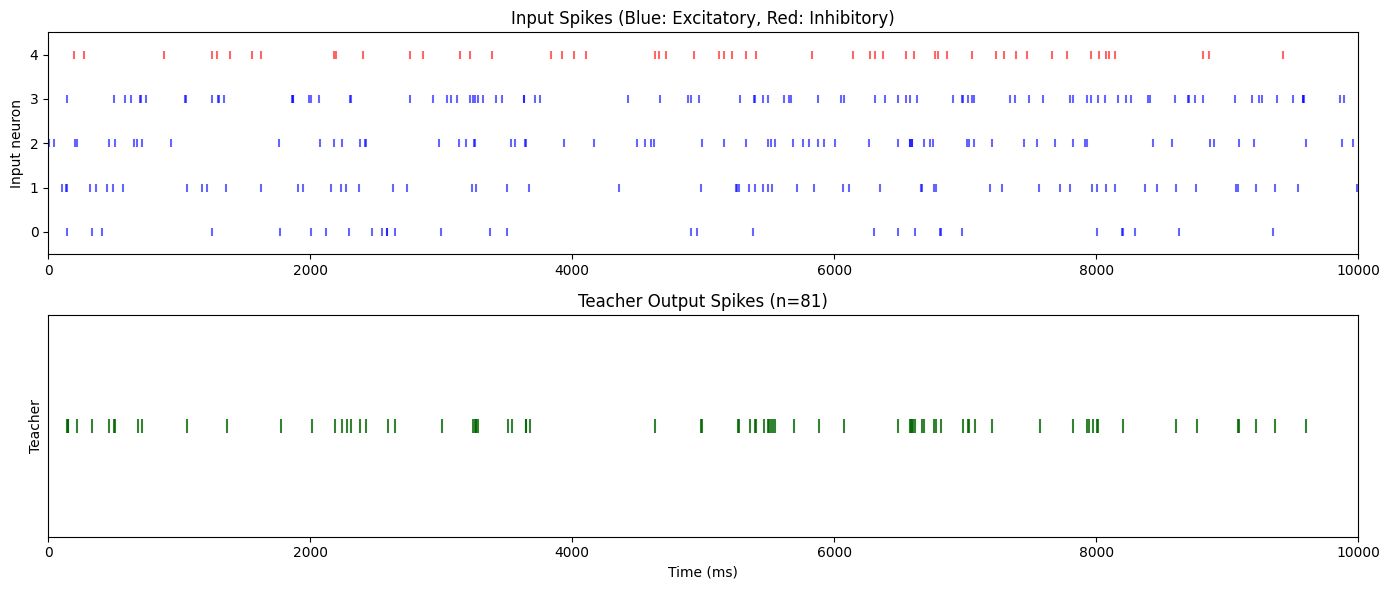

Teacher spike count: 81
Teacher firing rate: 8.10 Hz


In [8]:
# Plot teacher network spikes
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Create time axis
time_axis = torch.arange(time_steps) * dt

# Plot 1: Input spikes (all 5 inputs)
ax = axes[0]
for i in range(4):
    exc_spike_times = (
        torch.nonzero(input_spikes_exc[0, :, i], as_tuple=True)[0].numpy() * dt
    )
    ax.scatter(
        exc_spike_times,
        [i] * len(exc_spike_times),
        marker="|",
        s=30,
        c="blue",
        alpha=0.6,
    )
for i in range(1):
    inh_spike_times = (
        torch.nonzero(input_spikes_inh[0, :, i], as_tuple=True)[0].numpy() * dt
    )
    ax.scatter(
        inh_spike_times,
        [4 + i] * len(inh_spike_times),
        marker="|",
        s=30,
        c="red",
        alpha=0.6,
    )
ax.set_ylabel("Input neuron")
ax.set_ylim(-0.5, 4.5)
ax.set_xlim(0, duration * 1000)
ax.set_title("Input Spikes (Blue: Excitatory, Red: Inhibitory)")
ax.set_yticks(range(5))

# Plot 2: Teacher output spikes
ax = axes[1]
teacher_spike_times = torch.nonzero(s_teacher[0], as_tuple=True)[0].numpy() * dt
ax.scatter(
    teacher_spike_times,
    [0] * len(teacher_spike_times),
    marker="|",
    s=100,
    c="darkgreen",
    alpha=0.8,
)
ax.set_ylabel("Teacher")
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(0, duration * 1000)
ax.set_xlabel("Time (ms)")
ax.set_title(f"Teacher Output Spikes (n={len(teacher_spike_times)})")
ax.set_yticks([])

plt.tight_layout()
plt.show()

print(f"Teacher spike count: {len(teacher_spike_times)}")
print(f"Teacher firing rate: {len(teacher_spike_times) / duration:.2f} Hz")

In [9]:
# Initialise student network
log_w_exc_student = torch.randn(4, requires_grad=True)  # log excitatory weights
log_w_inh_student = torch.randn(1, requires_grad=True)  # log inhibitory weights
w_exc = torch.exp(log_w_exc_student)
w_inh = torch.exp(log_w_inh_student)

In [10]:
# Define van Rossum loss
class VanRossumLoss:
    """
    Van Rossum distance loss for spike trains with exponential filtering.

    The van Rossum distance measures the distance between spike trains by
    convolving them with an exponential kernel and computing the squared
    difference.
    """

    def __init__(self, tau: float, dt: float, batch_size: int = 1):
        """
        Initialize the van Rossum loss.

        Args:
            tau: Time constant for exponential filter in ms
            dt: Time step in ms
            batch_size: Batch size for initializing filtered states
        """
        self.tau = tau
        self.dt = dt
        self.batch_size = batch_size
        self.alpha = torch.exp(torch.tensor(-dt / tau))
        self.reset()

    def reset(self):
        """Reset the internal filtered state and history."""
        self.filtered_teacher = torch.zeros((self.batch_size,))
        self.filtered_student = torch.zeros((self.batch_size,))
        self.history_teacher = []
        self.history_student = []

    def __call__(
        self, s_student: torch.Tensor, s_teacher: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute van Rossum loss between student and teacher spike trains.

        Args:
            s_student: (batch, time) student spike train
            s_teacher: (batch, time) teacher spike train

        Returns:
            Scalar loss value
        """
        batch_size = s_student.shape[0]
        time_steps = s_student.shape[1]

        loss = 0.0

        # Accumulate loss over time steps
        for t in range(time_steps):
            # Update filtered spike trains with exponential decay
            self.filtered_teacher = self.filtered_teacher * self.alpha + s_teacher[:, t]
            self.filtered_student = self.filtered_student * self.alpha + s_student[:, t]

            # Record history
            self.history_teacher.append(self.filtered_teacher.clone())
            self.history_student.append(self.filtered_student.clone())

            # Compute squared difference
            diff = self.filtered_student - self.filtered_teacher
            loss += torch.sum(diff**2)

        # Normalize by time steps and batch size
        loss = loss / (time_steps * batch_size)

        return loss


loss_fn = VanRossumLoss(tau=20.0, dt=dt, batch_size=1)

In [11]:
# Setup training
optimizer = torch.optim.Adam([log_w_exc_student, log_w_inh_student], lr=0.03)
n_epochs = 100

# Track training history
weight_exc_history = []
weight_inh_history = []
loss_history = []

# Training loop
pbar = tqdm(range(n_epochs), desc="Training")
for epoch in pbar:
    # Reset loss state
    loss_fn.reset()

    # Update global weights from log weights
    w_exc = torch.exp(log_w_exc_student)
    w_inh = torch.exp(log_w_inh_student)

    # Run student network
    v_student, g_exc_student, g_inh_student, s_student, _, _, _ = conductance_neuron(
        v_init, g_exc_init, g_inh_init, input_spikes_exc, input_spikes_inh
    )

    # Compute loss
    loss = loss_fn(s_student, s_teacher)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track history
    weight_exc_history.append(torch.exp(log_w_exc_student).detach().clone())
    weight_inh_history.append(torch.exp(log_w_inh_student).detach().clone())
    loss_history.append(loss.item())

    # Update progress bar message
    pbar.set_postfix({"Loss": f"{loss.item():.6f}"})

Training: 100%|██████████| 100/100 [11:19<00:00,  6.80s/it, Loss=0.090529]


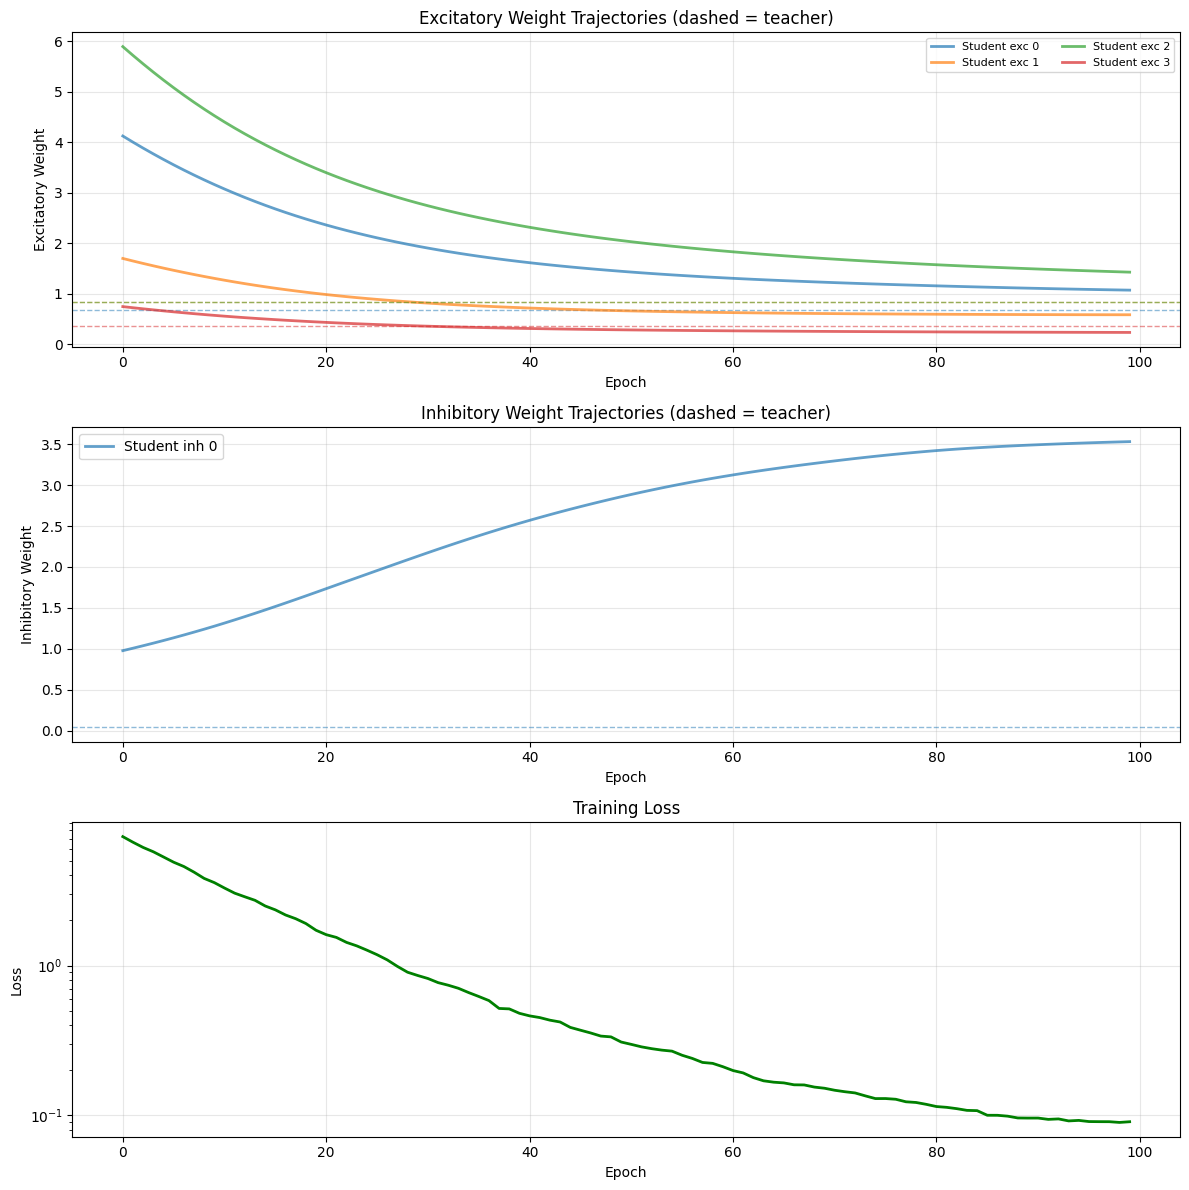

Excitatory weights:
  Neuron 0: Student=1.0758, Teacher=0.6761, Diff=0.3997
  Neuron 1: Student=0.5885, Teacher=0.8401, Diff=0.2516
  Neuron 2: Student=1.4320, Teacher=0.8489, Diff=0.5831
  Neuron 3: Student=0.2384, Teacher=0.3680, Diff=0.1296

Inhibitory weights:
  Neuron 0: Student=3.5308, Teacher=0.0403, Diff=3.4905


In [12]:
# Plot weight trajectories
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Convert histories to arrays
weight_exc_array = torch.stack(weight_exc_history).numpy()  # (n_epochs, 4)
weight_inh_array = torch.stack(weight_inh_history).numpy()  # (n_epochs, 1)

# Plot 1: Excitatory weight trajectories
ax = axes[0]
for i in range(4):
    ax.plot(weight_exc_array[:, i], alpha=0.7, linewidth=2, label=f"Student exc {i}")
    ax.axhline(
        y=w_teacher_exc[i].item(), color=f"C{i}", linestyle="--", linewidth=1, alpha=0.5
    )
ax.set_xlabel("Epoch")
ax.set_ylabel("Excitatory Weight")
ax.set_title("Excitatory Weight Trajectories (dashed = teacher)")
ax.legend(ncol=2, fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Inhibitory weight trajectories
ax = axes[1]
for i in range(1):
    ax.plot(weight_inh_array[:, i], alpha=0.7, linewidth=2, label=f"Student inh {i}")
    ax.axhline(
        y=w_teacher_inh[i].item(), color=f"C{i}", linestyle="--", linewidth=1, alpha=0.5
    )
ax.set_xlabel("Epoch")
ax.set_ylabel("Inhibitory Weight")
ax.set_title("Inhibitory Weight Trajectories (dashed = teacher)")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Loss trajectory
ax = axes[2]
ax.plot(loss_history, "g-", linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("Excitatory weights:")
for i in range(4):
    print(
        f"  Neuron {i}: Student={weight_exc_array[-1, i]:.4f}, Teacher={w_teacher_exc[i].item():.4f}, Diff={abs(weight_exc_array[-1, i] - w_teacher_exc[i].item()):.4f}"
    )
print("\nInhibitory weights:")
for i in range(1):
    print(
        f"  Neuron {i}: Student={weight_inh_array[-1, i]:.4f}, Teacher={w_teacher_inh[i].item():.4f}, Diff={abs(weight_inh_array[-1, i] - w_teacher_inh[i].item()):.4f}"
    )